# PS6: Let's Build a Multiple Asset Synthetic Data Generation System 
In this problem set, you will build a synthetic data generation system for multiple assets. The goal is to create a framework that allows you to simulate the price movements of various financial assets over time, taking into account correlations between them. 

> __Learning Objectives:__
>
> By the end of this problem set, you will be able to:
> * __Generate encoded state sequences from Hidden Markov Models:__ Sample discrete state trajectories from trained HMM instances and track jump events across multiple simulation paths.
> * __Decode Hidden Markov Model predictions into growth rates:__ Transform discrete HMM states into growth rate values using distribution models and extend predictions to multiple assets using the single index model.
> * __Analyze statistical properties of simulated data:__ Compare simulated and observed distributions using statistical tests and examine autocorrelation and volatility clustering patterns.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We use daily open-high-low-close (OHLC) data for firms in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for exchange-traded funds and volatility products.

Load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 483 entries:
  "NI"   => 220×8 DataFrame…
  "EMR"  => 220×8 DataFrame…
  "CTAS" => 220×8 DataFrame…
  "HSIC" => 220×8 DataFrame…
  "KIM"  => 220×8 DataFrame…
  "PLD"  => 220×8 DataFrame…
  "IEX"  => 220×8 DataFrame…
  "BAC"  => 220×8 DataFrame…
  "CBOE" => 220×8 DataFrame…
  "EXR"  => 220×8 DataFrame…
  "NCLH" => 220×8 DataFrame…
  "CVS"  => 220×8 DataFrame…
  "DRI"  => 220×8 DataFrame…
  "DTE"  => 220×8 DataFrame…
  "ZION" => 220×8 DataFrame…
  "AVY"  => 220×8 DataFrame…
  "EW"   => 220×8 DataFrame…
  "EA"   => 220×8 DataFrame…
  "NWSA" => 220×8 DataFrame…
  ⋮      => ⋮

Not all tickers have the maximum number of trading days due to acquisition or delisting events. Collect only tickers with the maximum number of trading days.

Compute the number of records for `AAPL` and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # maximum number of trading days in our dataset

220

Iterate through the data and collect only tickers with `maximum_number_trading_days` records. Save the data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Get a list of firms in the cleaned dataset and sort them alphabetically. Store the sorted ticker symbols in the `list_of_tickers_price_data::Array{String,1}` variable:

In [5]:
list_of_tickers_price_data = keys(dataset) |> collect |> sort; # list of tickers in our dataset

Next, let's load the HMM model that we estimated using historical data (2014 - 2024). First, we specify the `path_to_save_file::String` variable:

In [6]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-SPY-N-100-daily-aggregate.jld2");

Load the [`HDF5` binary file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) using [the `load(...)` function from JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git). This loads the saved data into the `saved_state_dict::Dict{String, Any}` variable.

In [7]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 11 entries:
  "risk_free_rate"          => 0.043
  "model"                   => MyHiddenMarkovModel([1, 2, 3, 4, 5, 6, 7, 8, 9, …
  "decode"                  => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-3.3565…
  "encoded_archive_with_ju… => [53 72 … 82 92; 93 82 … 80 5; … ; 14 67 … 87 13;…
  "insampledataset"         => [-0.62754, 0.839626, 0.162992, -0.0111337, 0.257…
  "jump_model"              => MyHiddenMarkovModelWithJumps([1, 2, 3, 4, 5, 6, …
  "encoded_archive"         => [48 29 … 28 33; 42 10 … 10 68; … ; 18 37 … 39 77…
  "number_of_states"        => 100
  "in_sample_decoded_archi… => [0.202562 0.962389 … 1.56531 2.7557; 2.94573 1.6…
  "stationary"              => Categorical{Float64, Vector{Float64}}(…
  "in_sample_decoded_archi… => [0.0753184 -0.675607 … -0.759002 -0.470222; -0.1…

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable. In addition, we return a few other useful variables, such as the historical market growth rate, the mean and variance of the market growth, etc.

> __Note:__ The `Ḡₘ::Float64` variable stores the historical mean of the market excess growth rate, which we will use later when simulating new paths.

The other returned variables are not needed for your part of this problem set (we use them, but you do not need to modify them).

In [8]:
sim_model_parameters,Gₘ,Ḡₘ,Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Gₘ = sim_model_parameters["Gₘ"]; # Get the past market growth rate 
    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates (not sure if this is excess, but we are going to assume it is)
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters,  Gₘ , Ḡₘ, Varₘ;
end;

What's in the `sim_model_parameters` variable? Let's take a look at the keys:

In [9]:
sim_model_parameters["AAPL"]

(ticker = "AAPL", n = 2766, p = 2, t = 1.96, alpha = 0.10605520914187136, beta = 1.1945864028660338, alpha_SE = 0.05142331293781634, beta_SE = 0.023948874510820575, alpha_95_CI_lower = 0.00526551578375134, alpha_95_CI_upper = 0.20684490249999138, beta_95_CI_lower = 1.1476466088248254, beta_95_CI_upper = 1.2415261969072422, training_variance = 1838.7010778838012)

Now let's get a list of all tickers for which we have single index model parameters:

In [10]:
tickers_that_we_have_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute [the intersection of the two lists](https://docs.julialang.org/en/v1/base/collections/#Base.intersect) and store the result in the `list_of_tickers::Array{String,1}` variable:

In [11]:
list_of_tickers = intersect(tickers_that_we_have_sim_data_for, list_of_tickers_price_data);

### Constants and Parameters
Finally, we set constants and parameters needed for the problem set. See the comments in the code for additional information on each parameter, units, permissible values, etc.

In [12]:
Δt = (1/252); # time step: 1 trading day in units of years
number_of_paths = 10000; # number of potential futures should we look at
blue_color = colorant"rgb(68,152,242)";
myticker = "SPY"; # ticker symbol for the SPY ETF
number_of_states = saved_state_dict["number_of_states"]; # number of hidden states in the HMM
risk_free_rate = saved_state_dict["risk_free_rate"]; # risk-free interest rate (annualized)
π̄ = saved_state_dict["stationary"]; # stationary distribution of the Markov chain
decode_distribution_model = saved_state_dict["decode"]; # decoded distribution model

### Growth Rate Calculation
Compute the daily growth rate time series for all firms. Store the growth rate time series in the `all_firms_excess_return_matrix::Array{Float64,2}` variable.

In [13]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Extract the growth rate for the `ticker::String` of interest and save in the `Rᵢ::Array{Float64,1}` array. This is the observed out-of-sample data.

In [14]:
Rᵢ = findfirst(x->x==myticker, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];

___

## Task 1: Generate Synthetic Growth Rate Trajectories for SPY
In this task, we will generate synthetic growth rate trajectories for the SPY ETF using the HMM parameters we estimated earlier. First, we'll generate encoded hidden state sequences for each synthetic path. Then, we'll decode these hidden state sequences to generate observable growth rates for each path.

Let's start by generating the encoded hidden state sequences for each synthetic path. We'll store the results in the `encoded_hidden_state_matrix::Array{Int64,2}` variable, where each row corresponds to a synthetic path and each column corresponds to a time step.

In [15]:
market_factor_encoded_archive, market_jump_indicator_archive = let
    
    model = saved_state_dict["jump_model"]; # TODO: need to load the jump_model so we have sample it!
    number_of_steps = 2*(maximum_number_trading_days - 1); # we'll generate paths twice as long as the original data
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    jump_indicator_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j,1]
            jump_indicator_archive[j,i] = tmp[j,2]
        end
    end
    encoded_archive, jump_indicator_archive
end

([6 92 … 97 74; 17 64 … 46 80; … ; 85 32 … 81 6; 55 76 … 82 67], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

__How many jumps?__ The `jump_indicator_archive::Array{Int64,2}` array holds jump indicators for each time step and sample path. A value of `1` indicates a jump, while `0` indicates no jump.

In [16]:
jump_trial_index_set = let
    
    # initialize -
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    has_jumps_flag = any(x->x==1, market_jump_indicator_archive);
    jump_trial_index_set = Set{Int64}();
    if (has_jumps_flag == false)
        println("No jumps were detected in the simulated paths.")
    end;

    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            if (market_jump_indicator_archive[j,i] == 1)
                push!(jump_trial_index_set, i);
            end
        end
    end
    println("Number of paths with at least one jump event: $(length(jump_trial_index_set)) out of $number_of_paths total paths.")

    jump_trial_index_set; # return the trial index set
end;

Number of paths with at least one jump event: 470 out of 10000 total paths.


The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. Sample these distributions to generate excess growth rate values corresponding to discrete states. Iterate through the `encoded_archive` array and sample the decode model associated with $s\in\mathcal{S}$, then save values in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):

> __How does this work?__ The outer loop iterates over sample paths (index `i`), while the inner loop iterates over time steps (index `j`). Inside the inner loop, select state `s`, access the corresponding Normal decode model for state `s` (the `j,i` element of `encoded_archive`), and sample that model [using `rand(...)` from Distributions.jl](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds excess growth rate values for each time step and sample path.

In [17]:
out_of_sample_decoded_archive = let

    # initialize -
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    
    # iterate through each path and time step to decode excess growth values
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = market_factor_encoded_archive[j,i];
            
            # TODO: fix the line below, so we can decode properly
            out_of_sample_decoded_archive[j,i] = decode_distribution_model[s] |> d-> rand(d); # TODO: need to decode the hidden state 's' into an actual excess growth value
        end
    end
    out_of_sample_decoded_archive; # actual excess growth value (not internal state variables)
end

438×10000 Matrix{Float64}:
 -3.00761    2.7716     2.27813      0.867087  …    4.04986       1.07906
 -1.4466     0.612401   0.600752     0.937909      -0.000409314   1.43734
  2.92858    0.280583   0.410587    -1.20877        1.48589       0.722869
 -7.74426    0.759688  -0.619007    -2.71181        0.784901     -0.133762
 -1.99736   -1.45546   -1.56575      0.32125        3.07319       1.08566
 -0.966794   1.01139    2.72117     -0.457323  …    1.19438       0.511682
  1.59543    1.78592    0.481802    -5.59906        4.38845       0.365436
 -0.817967  -0.460589  -0.049924    -3.21586       -1.05829      -2.79245
  0.407548  -0.214628  -1.82653     -0.365958      -2.09767      -1.76925
  2.16421   -0.533086  -0.0339619   -3.24309        1.91756      -4.98882
  ⋮                                            ⋱                 
 -0.181368   2.41833    0.344136     0.094266      -0.396171      0.965608
  4.78042   -1.6593    -0.31841     -0.154375  …  -11.792        -0.851456
  0.487847   

Unhide the code block below to see the observed and simulated excess annual growth rate distribution for the out-of-sample data.

> __Summary__: The simulated out-of-sample excess growth rate distributions (blue lines) and the observed distribution (red line) are qualitatively similar. The simulated distributions appear more heavily tailed, with more density for near-zero growth rates and broader tails.

Do our simulations pass the eye test?

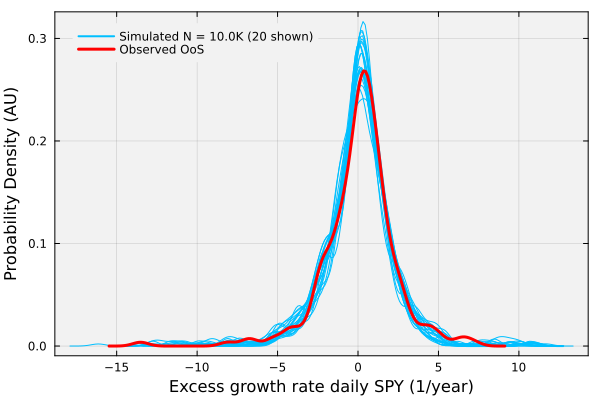

In [18]:
let
    
    # initialize
    N = 20; # how many random paths to plot
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    random_index_set = rand(1:number_of_paths, N);

    q = plot(); 
    density!(out_of_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated N = $(number_of_paths/1000)K ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ random_index_set
        density!(out_of_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(Rᵢ, c=:red, lw=3, label="Observed OoS")
    xlabel!("Excess growth rate daily $(myticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

The eye test is a subjective visual assessment of whether two distributions appear similar based on their graphical representations. However, let's perform a more rigorous statistical test to compare the simulated and observed distributions.

If the Markov model is correct, the observed excess growth rate distribution and the model-predicted distributions should be drawn from the same distribution. Check this hypothesis using [ApproximateTwoSampleKSTest from HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl).

> __Test:__ `H0:null hypothesis` is that $x$ and $y$ are drawn from the same distribution against the `H1:alternative hypothesis` that $x$ and $y$ come from different distributions. Perform the test on each of the `number_of_paths` sample trajectories and compute an overall score. 

This test is a little confusing, so let's dig into what our `pvalue_cutoff::Float64` means:

> __KS-Test Interpretation:__ The Kolmogorov-Smirnov (KS) test compares the cumulative distribution functions (CDFs) of two samples $x$ and $y$ to determine if they are drawn from the same distribution. We construct the empirical CDFs for both samples and calculate the maximum difference between them, known as the KS statistic.
> * If $x$ and $y$ look different, the difference between their cumulative distributions is large. The probability $p$ of observing a difference that is even larger is small. A small $p$ implies we reject that $x$ and $y$ are drawn from the same distribution.
> * If $x$ and $y$ look similar, the difference between their cumulative distributions is small. The probability $p$ of observing a difference that is even larger is high. A large $p$ implies we fail to reject that $x$ and $y$ are drawn from the same distribution.

So what do we see? We save the indices of the simulated paths that pass the KS test in the `index_set_pass_KS_test_SPY::Set{Int64}` variable:

In [19]:
index_set_pass_KS_test_SPY = let
    
    # initialize -
    index_set_pass_KS_test = Set{Int64}();
    R = Rᵢ; # observed OoS excess growth rate for myticker
    pvalue_cutoff = 0.05; # if we choose a larger p-value cutoff, we reject the H0 more often (really tight test)
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(R, out_of_sample_decoded_archive[:,i]) |> pvalue   
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
            push!(index_set_pass_KS_test, i);
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
    
    # check: we should have at least one path that passed the KS-test
    @assert length(index_set_pass_KS_test) > 0 "No simulated paths passed the KS-test. Try decreasing (making less strict) the p-value cutoff."
    
    index_set_pass_KS_test;
end;

Pass percentage: 98.65%


We see a pretty good match! A large number of simulated paths pass the KS-test, indicating that their distributions are statistically similar to the observed out-of-sample distribution.

But what can we do with this information? Let's use our simulated SPY trajectories to generate synthetic growth rate trajectories for other assets using the single index model.

___

## Task 2: Extend the HMM Simulation to Multiple Assets
In this task, we will extend our synthetic data generation system to generate growth rate data for multiple assets. We'll generate synthetic growth rate trajectories for a list of tickers using the SPY HMM model as a market factor in combination with the single index model for each asset. 

> __Single Index Model Recap (SIM)__
> 
> Single index models are factor models that consider only the return (growth) of the market factor. These models were originally developed by Sharpe in 1963: [Sharpe, William F. (1963). "A Simplified Model for Portfolio Analysis". Management Science, 9(2): 277-293. doi:10.1287/mnsc.9.2.277.](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.9.2.277)
>
> Suppose the excess growth of firm $i$ at time $t$ is denoted by $G^{(t)}_{i}$. Then, the single index model of the return (growth rate) is given by:
> $$
G^{(t)}_{i} = \alpha_{i} + \beta_{i}\;G^{(t)}_{M} + \epsilon^{(t)}_{i}
$$
> where $\alpha_{i}$ is the _idiosyncratic (firm-specific) growth_, $\beta_{i}$ is the component of the growth rate of firm $i$ explained by the market (it is also a measure of risk), $G^{(t)}_{M}$ is the excess growth rate of the market index at time $t$, and $\epsilon^{(t)}_{i}$ denotes an error term associated with firm $i$ (describes growth rate not captured by the firm or market factors). The expected excess growth rate for firm $i$ at time $t$ is given by:
> $$
\mathbb{E}\left[G^{(t)}_{i}\right] = \alpha_{i} + \beta_{i}\;\mathbb{E}\left[G^{(t)}_{M}\right]   
$$
> In this task, we will use the simulated market excess growth rates from the SPY HMM model to estimate $\mathbb{E}\left[G^{(t)}_{M}\right]$, and then we will generate synthetic excess growth rates for other assets $\mathbb{E}\left[G^{(t)}_{i}\right]$ using the single index model.

Let's start by specifying a list of tickers for which we want to generate synthetic data. These tickers must be included in the `list_of_tickers::Array{String,1}` variable defined earlier, i.e., we have price and single index model parameters for these tickers. Let's store these tickers in the `my_tickers_to_simulate::Array{String,1}` variable:

In [20]:
my_tickers_to_simulate = ["AAPL", "AAL", "AMZN", "MSFT", "MU", "NVDA", "AMD", "PG", "COST", "TGT", "LLY", "PFE", "MRK", "JNJ", 
"GS", "JPM", "BAC", "C", "F", "T", "UPS", "TSLA"]; # TODO: specify a list of tickers (Strings) to simulate. The next section checks that the tickers that you specify are valid. Pick at least 3 tickers!

Let's check that all the tickers in `my_tickers_to_simulate` are included in `list_of_tickers`:

In [21]:
let
    
    # check that all tickers are in our dataset
    for ticker ∈ my_tickers_to_simulate
        if !(ticker ∈ list_of_tickers)
            error("Ticker $ticker is not in the dataset.")
        end
    end
    println("All $(length(my_tickers_to_simulate)) tickers are valid and present in the dataset.")
end;

All 22 tickers are valid and present in the dataset.


If we get here (without an error), all tickers are valid! Nice. Now, we can proceed to generate synthetic growth rate trajectories for each ticker in `my_tickers_to_simulate` using the SPY HMM model and the single index model parameters.

> __What is happening here?__ For each ticker in `my_tickers_to_simulate`, we extract the single index model parameters (alpha, beta) from the `sim_model_parameters::Dict{String,NamedTuple}` variable. We then compute the simulated excess growth rates for each time step and sample path using the decoded market excess growth rates from the SPY HMM model. We save the simulated growth rates to a file for each ticker.

__A quick word of caution:__ The simulated growth rate files (with the default parameters) can be large (approximately 35 megabytes). Make sure you have enough disk space before running the code below if you have a lot of tickers to simulate.

In [22]:
let

    # initialize -
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);

    @showprogress dt=1 desc="Computing..." for ticker ∈ my_tickers_to_simulate

        # we'll save simulated growth rates to disk
        path_to_save_file = joinpath(_PATH_TO_SIMS,"SIMULATED-GROWTH-RATES-$(ticker)-HMM-WJ-SPY-N-100-daily-aggregate.jld2");
        if (isfile(path_to_save_file))
            println("Simulated growth rates for ticker $(ticker) already exist. Skipping simulation.");
            continue; # skip to next ticker
        end
        
        # Get the single index model parameters for this ticker
        parameters = sim_model_parameters[ticker];
        α = parameters.alpha;
        β = parameters.beta;

        # initialize simulated price archive
        simulated_growth_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
        
        # TODO: uncomment and fix the line below. We need to set the initial expected excess growth rate for all paths
        simulated_growth_archive[1,:] .= α + (Ḡₘ)*β; # compute the *initial* expected excess growth rate for all paths

        # populate the simulated growth archive
        for i ∈ 1:number_of_paths
            for j ∈ 2:number_of_steps
                Gₘ = out_of_sample_decoded_archive[j-1,i]; # market excess growth rate for time step
                
                # TODO: fix the line below to compute the decoded excess growth rate for ticker
                simulated_growth_archive[j,i] = α + (Gₘ)*β; # TODO: need to compute the decoded excess growth rate for ticker using the single index model
            end
        end

        # write this to disk -
        save(path_to_save_file, Dict("data" => simulated_growth_archive));
    end
end

Simulated growth rates for ticker AAPL already exist. Skipping simulation.
Simulated growth rates for ticker AAL already exist. Skipping simulation.


Computing... 100%|███████████████████████████████████████| Time: 0:00:01


Simulated growth rates for ticker AMZN already exist. Skipping simulation.
Simulated growth rates for ticker MSFT already exist. Skipping simulation.
Simulated growth rates for ticker MU already exist. Skipping simulation.
Simulated growth rates for ticker NVDA already exist. Skipping simulation.
Simulated growth rates for ticker AMD already exist. Skipping simulation.
Simulated growth rates for ticker PG already exist. Skipping simulation.
Simulated growth rates for ticker COST already exist. Skipping simulation.
Simulated growth rates for ticker TGT already exist. Skipping simulation.
Simulated growth rates for ticker LLY already exist. Skipping simulation.
Simulated growth rates for ticker PFE already exist. Skipping simulation.
Simulated growth rates for ticker MRK already exist. Skipping simulation.
Simulated growth rates for ticker JNJ already exist. Skipping simulation.
Simulated growth rates for ticker GS already exist. Skipping simulation.
Simulated growth rates for ticker JPM

___

## Task 3: Do the Simulated Growth Rates Capture the Stylized Facts of the Observed Data?
In this task, we will analyze the simulated growth rate trajectories for the tickers in `my_tickers_to_simulate::Array{Float64,2}` and compare them to the observed out-of-sample growth rate trajectories. We will compute various statistical properties of the simulated and observed data, such as mean, variance, autocorrelation, and volatility clustering.

First, let's use the __eye test__ to compare the simulated and observed growth rate distributions for a ticker in `my_tickers_to_simulate`. We'll plot the distributions side by side for visual comparison. Specify the ticker  you want to visualize (this is the list of tickers that you just simulated) in the `my_ticker_to_plot::String` variable:

In [23]:
my_ticker_to_plot = "AAPL";
simulated_growth_file_path = joinpath(_PATH_TO_SIMS,"SIMULATED-GROWTH-RATES-$(my_ticker_to_plot)-HMM-WJ-SPY-N-100-daily-aggregate.jld2");
simulated_growth_data = load(simulated_growth_file_path)["data"];

### Check: Are the predicted and observed out-of-sample distributions the same?
Let's do the KS-test again on the simulated growth rates for `my_ticker_to_plot`. We'll store the indices of the simulated paths that pass the KS test in the `index_set_pass_KS_test::Set{Int64}` variable:

In [24]:
index_set_pass_KS_test = let
    
    # initialize -
    index_set_pass_KS_test = Set{Int64}();
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    pvalue_cutoff = 0.05; # if we choose a larger p-value cutoff, we reject the H0 more often (really tight test)
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(R, simulated_growth_data[:,i]) |> pvalue   
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
            push!(index_set_pass_KS_test, i);
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
    
    # check: we should have at least one path that passed the KS-test
    @assert length(index_set_pass_KS_test) > 0 "No simulated paths passed the KS-test. Try decreasing (making less strict) the p-value cutoff."
    
    index_set_pass_KS_test;
end;

Pass percentage: 62.74999999999999%


Let's check a random sample from those that passed the KS-test.

In [25]:
let
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    t = ApproximateTwoSampleKSTest(R, simulated_growth_data[:,rand(index_set_pass_KS_test)])
end

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0821918

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.2774

Details:
    number of observations:   [219,438]
    KS-statistic:              0.9931270663228415


Now, let's plot `N` random paths from those that passed the KS-test for `my_ticker_to_plot`. 

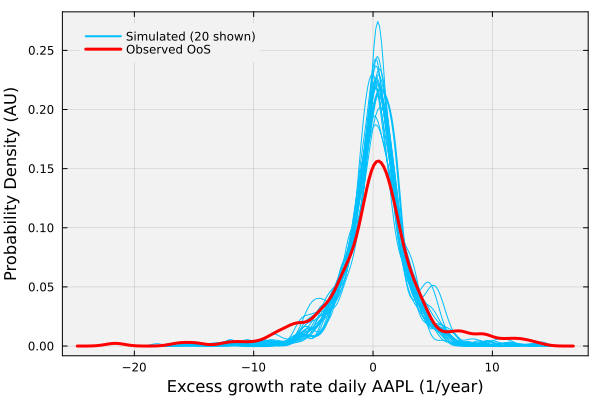

In [26]:
let

    # initialize -
    (number_of_steps, number_of_paths) = size(simulated_growth_data);
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];
    N  = min(20, length(index_set_pass_KS_test)); # how many random paths to plot
    index_vector_to_plot = collect(index_set_pass_KS_test)[1:N];

    q = plot(); 
    density!(simulated_growth_data[:,1], lw=2, c=:deepskyblue1, label="Simulated ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ index_vector_to_plot
        density!(simulated_growth_data[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(R, c=:red, lw=3, label="Observed OoS")
    xlabel!("Excess growth rate daily $(my_ticker_to_plot) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Mean and standard deviation of the out-of-sample data
Check if the simulated values bound the observed mean and standard deviation for the out-of-sample data.

> __Simulated mean and standard deviation__
> 
> Compute the mean over the time dimension (rows) of the `simulated_growth_data` array using [the `mean(...)` function with `dim = 1`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean). This returns `number_of_paths` values for the mean (one per sample path), i.e., an estimated mean for each potential simulated future. To compute the mean over sample paths (simulated futures), use [the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the simulated sample mean as the `μ̄::Float64` variable.
> 
> Compute the standard deviation over time and then over the `number_of_paths` sample paths using [the `std(...)` function with `dim = 1`](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.std), which produces `number_of_paths` estimates of the standard deviation of the growth. Use [the `mean(...)` function again](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) and the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to compute the overall mean volatility. Save the simulated sample standard deviation (volatility) as the `σ̄::Float64` variable:

Let's look at two tests: the first test checks the mean.

__Test I:__ Test whether the observed out-of-sample excess growth rate mean is contained in a $\pm$ `SEM` range around the mean computed over simulation samples: 
$$
\mu \in R_{\mu} \equiv \left[\bar{\mu}-z_{\alpha/2}\frac{\bar{\sigma}}{\sqrt{N}},\,\bar{\mu}+z_{\alpha/2}\frac{\bar{\sigma}}{\sqrt{N}}\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\mu\notin{R}_{\mu}$, i.e., the observed mean is not bounded by $\pm$`SEM`, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), where `SEM` denotes the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

In [27]:
let

    # initialize -
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    X = simulated_growth_data[:,collect(index_set_pass_KS_test)]; # only those that passed the KS-test
    μ̄ = mean(X, dims=1) |> x -> mean(x); # average *predicted* mean
    σ̄ = std(X, dims=1) |> x -> mean(x); # average *predicted* standard deviation
    μ = mean(R, dims=1) |> first; # observed growth rate from data
    σ = std(R, dims=1) |> first; # observed standard deviation from data
   
    # Test 1: Construct 95% confidence interval for the predicted mean growth rate, are we in it?
    z = 2.576; # 99% confidence
    region = (μ̄ - z*σ̄/√number_of_paths, μ̄ + z*σ̄/√number_of_paths);
    istrueflag = (region[1] ≤ μ && μ ≤ region[2])
    println("R = $(region) at CI = 99% where μ (obs) = $(μ), μ̄ (sim) = $(μ̄). Do we capture the observed OoS mean? $(istrueflag)")
end

R = (0.0761293416421165, 0.2134366326708625) at CI = 99% where μ (obs) = 0.06811896283858287, μ̄ (sim) = 0.1447829871564895. Do we capture the observed OoS mean? false


__Test II:__ Test the simulated versus observed standard deviation of the excess growth for the out-of-sample values:
$$
\sigma\in R_{\sigma} \equiv \left[\sqrt\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{r}^2},\,\sqrt{\frac{(N-1)\cdot\bar{\sigma}^2}{\chi_{l}^2}}\,\right]
$$
using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). If $\sigma\notin{R}_{\sigma}$, i.e., the observed standard deviation is not bounded by $\pm\sqrt{(N-1)\cdot{\bar{\sigma}^{2}}/\chi_{\star}^{2}}$, then an [AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Where $\chi_{\star}^{2}$ denotes the $\star=\left\{l,r\right\}$ left (`l`) or right (`r`) tail of the [chi-squared distribution with $N − 1$ degrees of freedom](https://en.wikipedia.org/wiki/Chi-squared_distribution). Use [the `Chisq(...)` distribution from Distributions.jl](https://github.com/JuliaStats/Distributions.jl) with [the `quantile(...)` function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) to compute $\chi_{\star}^{2}$ values:

In [28]:
let

    # initialize -
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    X = simulated_growth_data[:,collect(index_set_pass_KS_test)]; # only those that passed the KS-test
    
    μ̄ = mean(X, dims=1) |> x -> mean(x); # average *predicted* mean
    σ̄ = std(X, dims=1) |> x -> mean(x); # average *predicted* standard deviation
    μ = mean(R, dims=1) |> first; # observed growth rate from data
    σ = std(R, dims=1) |> first; # observed standard deviation from data
    α = 0.99;
    ᾱ = (1 - α);
    chi_d = Chisq(number_of_paths - 1);
    χₗ = quantile(chi_d,ᾱ);
    χᵣ = quantile(chi_d,α);

    # Run TestII: Construct 99% confidence interval for the predicted standard deviation, are we in it?
    region = (sqrt(((number_of_paths - 1)*σ̄^2)/(χᵣ)), sqrt(((number_of_paths - 1)*σ̄^2)/(χₗ)));
    istrueflag = (region[1] ≤ σ && σ ≤ region[2])
    println("R = $(region) at CI = $(100*α)% and σ = $(σ), σ̄ = $(σ̄). Do we capture the observed OoS standard deviation? $(istrueflag)")
end

R = (2.6219631875625184, 2.7096688207185853) at CI = 99.0% and σ = 4.415778467852976, σ̄ = 2.66512599046479. Do we capture the observed OoS standard deviation? false


Finally, let's look at the autocorrelation and the volatility clustering of the simulated versus observed out-of-sample data. Let's look at random samples selected from those that passed the KS-test.

In [29]:
index_to_plot = rand(index_set_pass_KS_test); # generate a random index from the index_set_pass_KS_test

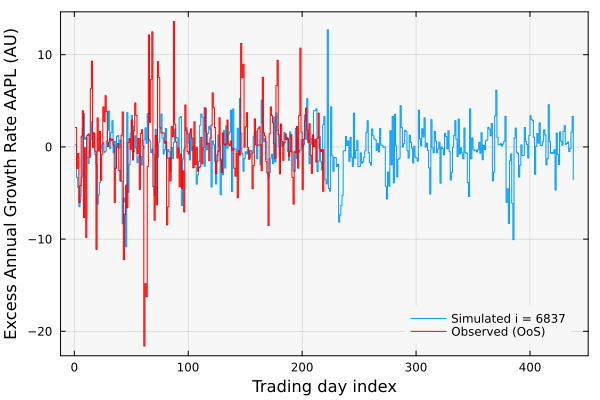

In [30]:
let
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot

    plot(simulated_growth_data[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(R, linetype=:steppost, c=:red, label="Observed (OoS)")
    xlabel!("Trading day index", fontsize=18)
    ylabel!("Excess Annual Growth Rate $(my_ticker_to_plot) (AU)", fontsize=18)
end

Now we look at the autocorrelation of the return (growth rate) time series.
> __Autocorrelation:__ The autocorrelation function (ACF) measures the correlation between a time series and a lagged version of itself over successive time intervals. It helps identify patterns, trends, and periodicities in the data. We expect that for single time steps (growth rates between day $i$ and day $i+1$), the autocorrelation is zero for all lags. However, this will not be the case for longer multi-day time series.

So what do we see?

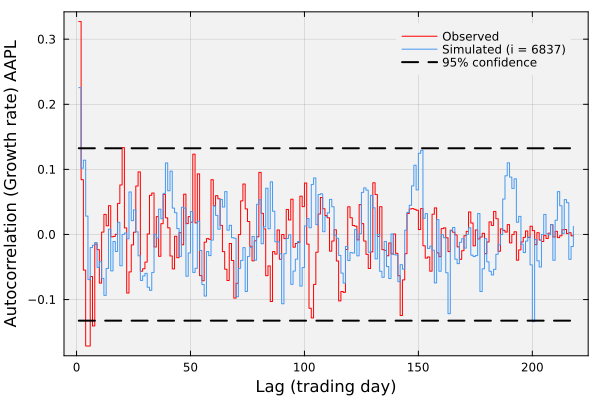

In [31]:
let
    # generate (or get) a random index -
    random_index = index_to_plot; # randomly selected path from those that passed the KS-test
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    number_of_steps = length(R);
    X = R;

    plot(autocor(X, (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor((simulated_growth_data[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=blue_color,
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation (Growth rate) $(my_ticker_to_plot)", fontsize=18)
end

Next, let's look at the volatility clustering of the simulated versus observed out-of-sample data. Let's look at random samples selected from those that passed the KS-test.

> __Volatility Clustering:__ Volatility clustering is a phenomenon in financial time series where large changes in asset prices tend to be followed by large changes (of either sign), and small changes tend to be followed by small changes. This phenomenon can be observed by examining the autocorrelation function of the absolute value of the excess growth rate time series.

So what do we see?

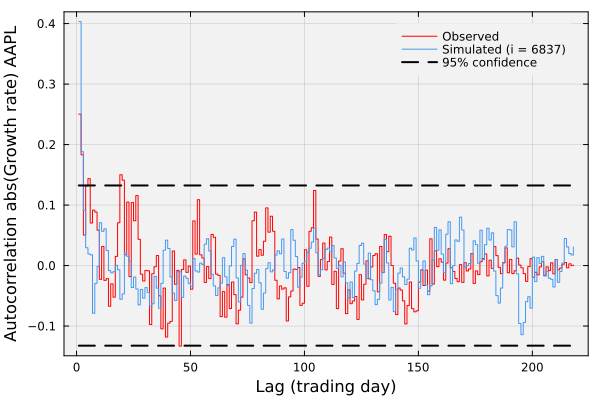

In [32]:
let
    # generate (or get) a random index -
    random_index = index_to_plot; # randomly selected path from those that passed the KS-test
    R = findfirst(x->x==my_ticker_to_plot, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i]; # observed OoS excess growth rate for my_ticker_to_plot
    number_of_steps = length(R);
    X = abs.(R);

    plot(autocor(X, (1:(number_of_steps-1) |> collect)), label="Observed", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost, lw = 1)
    plot!(autocor(abs.(simulated_growth_data[:,random_index]), ((1:(number_of_steps - 1)) |> collect)), c=blue_color,
        label="Simulated (i = $(random_index))", linetype=:steppost, lw = 1)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs(Growth rate) $(my_ticker_to_plot)", fontsize=18)
end

___

## Dicussion
Now that you have completed the synthetic data generation and analysis, let's consider some questions.

### Question 1: When is the Single Index Model Appropriate for Synthetic Data?

Consider the single index model we used to generate synthetic growth rates for individual assets from the market growth rates simulated using the HMM. The single index model is given by:
$$G^{(t)}_i = \alpha_i + \beta_i G^{(t)}_M + \epsilon^{(t)}_i$$

Think about a portfolio of assets and discuss the following:

* __What characteristics should a set of assets have for the SIM to be a good model for generating synthetic data?__ (Hint: Think about what types of assets would be well-explained by market movements.)
* __Can you think of scenarios or asset classes where the SIM might perform poorly?__ (Hint: Consider idiosyncratic events, sector-specific shocks, or company-specific news.)
* __How might the choice of market index (SPY, DIA, Russell 2000, etc.) affect the quality of your synthetic data generation?__

Put your discussion answers here.

**__Answer__**: 

* SIM works best when the assets in the portfolio are broadly driven by overall market movements, such as when the returns are highly correlated with a common market factor. So large-cap stocks, diversified sector ETFs, and index constituents can be good sets of assets for SIM to work well. In these cases, most of the return variation can be explained by the market return $G_M^{(t)}$, with $\beta_i$ capturing systematic risk and $\epsilon_i^{(t)}$ capturing small noise. In conclusion, when assets are liquid, well-diversified, and not dominated by firm-specific shocks, SIM generates realistic and structurally consistent synthetic data.

* SIM might perform poorly for assets dominated by idiosyncratic events or sector-specific shocks. For instance, biotech stocks driven by FDA approvals, or small-cap growth stocks influenced by speculative sentiment can cause SIM to perform poorly. Other events like firms affected by lawsuits or commodities with supply disruptions can also influence SIM. During periods of regime change (financial crises, wars, or policy interventions), SIM also performs badly. In these settings, the single-factor structure is too restrictive and fails to capture multi-dimensional risk sources.

* The quality of synthetic data depends on how well the chosen index represents the true systematic risk of the asset universe. For example, SPY is appropriate for large-cap U.S. equities, DIA fits blue-chip industrial stocks, while Russell 2000 is better for small-cap stocks. A mismatch between asset type and index may lead to biased $\beta_i$ estimates and distorted synthetic returns. More importantly, if the index poorly reflects the underlying market exposure of the assets, the generated synthetic data will misrepresent both volatility structure and correlation behavior.

In [33]:
did_I_answer_discussion_question_1 = true; # set to true if you answered the question

### Question 2: Model Validation and Risk Management When Reality Diverges from Predictions

Our synthetic data generation system relies on the Single Index Model and HMM predictions. However, real markets can behave unexpectedly due to idiosyncratic shocks.

> __Scenario:__ Suppose the SPY ETF experiences a stable or slightly positive day (market return is flat), but one of your portfolio stocks (e.g., Apple) experiences negative news. Perhaps there's a disappointing earnings announcement, regulatory concerns, or an executive departure. Despite the SIM predicting a stable or positive return based on the market movement, the stock's actual price drops.

Consider the following questions:

* __How would you detect and identify situations where the model's predictions significantly diverge from observed market reality?__ (Hint: What statistical tests or monitoring systems could you implement to flag such divergences?)
* __What risk management policies could you implement to protect against model failures?__ (Consider: Should you reduce position sizes? Halt trading? Require additional validation before acting?)
* __Could you use a combination of models to improve robustness?__ (For example, what additional factors beyond market returns might improve predictions for individual stocks?)

Put your discussion answers here.

**__Answer__**: 

* To detect whether model's predictions diverge or not, we want to monitor prediction errors (residuals) in real time. That is, for each stock, track the difference between realized return and the SIM-predicted return. Then, we can see check for large residuals (e.g., beyond 3 standard deviations) and trigger “model exception” flags. Additionally, we could implement rolling backtests, control charts, or CUSUM tests to detect drift in model performance, and monitor metrics like RMSE, MAPE, and hit ratios over time. Sudden jumps in these error measures, especially concentrated on a single name or sector, can be clear sign that SIM is no longer capturing current market dynamics. 

* When significant divergences are detected, we can implement the following risk management policies. For example, reducing position sizes in names with large unexplained moves, imposing stop-loss or max daily loss limits, or temporarily halting new trades that rely heavily on the faulty model. We can also implement human review or additional checks (news/earnings scan, alternative valuation metrics) before executing model-driven trades. Additionally, at the portfolio level, we might cap aggregate exposure to assets with high residual volatility and increase diversification or hedge with index options when models show signs of instability.

* To improve robustness beyond a pure SIM + HMM, we can use ensemble or multi-factor approaches. For example, add factors such as sector/industry indices, size, value, momentum, volatility, or macro variables to capture more dimensions of risk. And combine statistical models (SIM, multi-factor regressions) with machine learning models that incorporate news sentiment, earnings surprises, and analyst revisions. Also, a model-averaging or voting scheme (where trades are executed only when several models agree) can reduce reliance on a single, potentially misspecified model and make the overall system more resilient to idiosyncratic shocks.

In [34]:
did_I_answer_discussion_question_2 = true; # set to true if you answered the question

___

## Summary
This problem set builds a synthetic data generation system for multiple assets using Hidden Markov Models and the single index model.

> __Key Takeaways:__
>
> * __Encoded state sequences provide the foundation for HMM predictions:__ Sampling from trained HMM instances generates discrete state trajectories that capture model dynamics. Jump indicators track regime changes across simulation paths.
> * __Decoding transforms discrete states into growth rate predictions for multiple assets:__ Distribution models associated with HMM states convert encoded sequences into growth rates. The single index model extends predictions to individual assets using market factors and asset-specific parameters.
> * __Statistical tests quantify the accuracy of simulated data:__ Confidence intervals validate that simulated means and standard deviations bound observed values. Autocorrelation and volatility clustering patterns in simulated data match observed patterns.

This system generates probabilistic forecasts with quantifiable uncertainty for multiple assets.
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, and so forth.

In [35]:
@testset verbose = true "CHEME 5800 PS6 Test Suite" begin
    
    @testset "Task 1: SPY Data Loading and HMM Setup" begin
        # Check that required variables exist
        @test isdefined(Main, :myticker)
        @test myticker == "SPY"
        
        # Check that dataset loaded correctly
        @test isdefined(Main, :dataset)
        @test isa(dataset, Dict)
        @test length(dataset) > 0
        
        # Check that SPY data is in dataset
        @test haskey(dataset, "SPY")
        
        # Check growth rates and constants
        @test isdefined(Main, :Rᵢ)
        @test isa(Rᵢ, Vector)
        @test length(Rᵢ) > 0
        @test all(isfinite.(Rᵢ))
        
        # Check HMM setup
        @test isdefined(Main, :saved_state_dict)
        @test isa(saved_state_dict, Dict)
        @test haskey(saved_state_dict, "jump_model")
        @test haskey(saved_state_dict, "stationary")
        @test haskey(saved_state_dict, "decode")
    end
    
    @testset "Task 1: Encoded and Decoded Archives" begin
        # Check encoded archive
        @test isdefined(Main, :market_factor_encoded_archive)
        @test isa(market_factor_encoded_archive, Matrix)
        @test eltype(market_factor_encoded_archive) <: Integer
        @test size(market_factor_encoded_archive, 2) == number_of_paths
        @test all(market_factor_encoded_archive .> 0)
        @test all(market_factor_encoded_archive .<= number_of_states)
        
        # Check jump indicators
        @test isdefined(Main, :market_jump_indicator_archive)
        @test isa(market_jump_indicator_archive, Matrix)
        @test size(market_jump_indicator_archive) == size(market_factor_encoded_archive)
        @test all(x -> x ∈ [0, 1], market_jump_indicator_archive)
        
        # Check decoded archive
        @test isdefined(Main, :out_of_sample_decoded_archive)
        @test isa(out_of_sample_decoded_archive, Matrix)
        @test eltype(out_of_sample_decoded_archive) <: AbstractFloat
        @test size(out_of_sample_decoded_archive) == size(market_factor_encoded_archive)
        @test all(isfinite.(out_of_sample_decoded_archive))
    end
    
    @testset "Task 1: Jump Analysis" begin
        # Check jump analysis
        @test isdefined(Main, :jump_trial_index_set)
        @test isa(jump_trial_index_set, Set)
        @test all(x -> 1 <= x <= number_of_paths, jump_trial_index_set)
    end
    
    @testset "Task 2: Multiple Asset Setup" begin
        # Check tickers list
        @test isdefined(Main, :my_tickers_to_simulate)
        @test isa(my_tickers_to_simulate, Vector)
        @test length(my_tickers_to_simulate) > 0
        @test all(isa.(my_tickers_to_simulate, String))
        
        # Check that all tickers are in dataset
        for ticker ∈ my_tickers_to_simulate
            @test haskey(dataset, ticker)
            @test haskey(sim_model_parameters, ticker)
        end
        
        # Check that tickers are in list_of_tickers
        @test all(ticker -> ticker ∈ list_of_tickers, my_tickers_to_simulate)
    end
    
    @testset "Task 3: Statistical Analysis Setup" begin
        # Check ticker selection for analysis
        @test isdefined(Main, :my_ticker_to_plot)
        @test isa(my_ticker_to_plot, String)
        @test my_ticker_to_plot ∈ list_of_tickers
        @test my_ticker_to_plot ∈ my_tickers_to_simulate
        
        # Check simulated growth data
        @test isdefined(Main, :simulated_growth_data)
        @test isa(simulated_growth_data, Matrix)
        @test eltype(simulated_growth_data) <: AbstractFloat
        @test size(simulated_growth_data, 2) == number_of_paths
        @test all(isfinite.(simulated_growth_data))
    end
    
    @testset "Task 3: KS Test Results" begin
        # Check KS test results
        @test isdefined(Main, :index_set_pass_KS_test)
        @test isa(index_set_pass_KS_test, Set)
        @test length(index_set_pass_KS_test) > 0
        @test all(x -> 1 <= x <= number_of_paths, index_set_pass_KS_test)
    end
    
    @testset "Task 3: Statistical Measures" begin
        # Check that statistical tests can be computed
        R = findfirst(x -> x == my_ticker_to_plot, list_of_tickers) |> i -> all_firms_excess_return_matrix[:, i]
        X = simulated_growth_data[:, collect(index_set_pass_KS_test)]
        
        # Compute means and standard deviations
        μ̄_test = mean(X, dims=1) |> x -> mean(x)
        σ̄_test = std(X, dims=1) |> x -> mean(x)
        μ_test = mean(R)
        σ_test = std(R)
        
        # Test that values are reasonable
        @test isfinite(μ̄_test)
        @test isfinite(σ̄_test)
        @test isfinite(μ_test)
        @test isfinite(σ_test)
        
        @test σ̄_test > 0
        @test σ_test > 0
        
        # Test that means and stds are in reasonable ranges
        @test abs(μ̄_test) < 10.0
        @test abs(μ_test) < 10.0
    end
    
    @testset "Task 3: Autocorrelation Computation" begin
        # Check that index for plotting is valid
        @test isdefined(Main, :index_to_plot)
        @test 1 <= index_to_plot <= number_of_paths
        @test index_to_plot ∈ index_set_pass_KS_test
    end

    @testset "Discussion Questions" begin
        @test isdefined(Main, :did_I_answer_discussion_question_1)
        @test did_I_answer_discussion_question_1 == true

        @test isdefined(Main, :did_I_answer_discussion_question_2)
        @test did_I_answer_discussion_question_2 == true
    end
    
end;

Test Summary:                            | Pass  Total  Time
CHEME 5800 PS6 Test Suite                |  110    110  0.9s
  Task 1: SPY Data Loading and HMM Setup |   15     15  0.4s
  Task 1: Encoded and Decoded Archives   |   15     15  0.3s
  Task 1: Jump Analysis                  |    3      3  0.0s
  Task 2: Multiple Asset Setup           |   49     49  0.1s
  Task 3: Statistical Analysis Setup     |    9      9  0.0s
  Task 3: KS Test Results                |    4      4  0.0s
  Task 3: Statistical Measures           |    8      8  0.0s
  Task 3: Autocorrelation Computation    |    3      3  0.0s
  Discussion Questions                   |    4      4  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes.__ No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy, is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make.__ Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___